![cover](./img/cover.png)

![training](./img/training_asian.png)

In [1]:
import AdvancedQF as aqf

import numpy as np
import pandas as pd
from time import time

import plotly.offline as po
import plotly.graph_objs as go

import ipywidgets as widgets
from ipywidgets import interact

from ipywidgets.embed import embed_minimal_html

po.init_notebook_mode(connected=True)

**a) Assuming $S_0=10$, $\mu = 3%$, $\sigma = 25%$, $K=9.5$ and $T=1$, approximate the asset dymanics with a 100-step Euler scheme and compute the option premium through a Monte Carlo simulation.**

In [2]:
# INPUT DATA
spot = 10.
strike = 9.5
mu = 0.03
sigma = 0.25
maturity = 1.

steps = 1000 #Euler steps
mc = 100000 #Monte Carlo paths

fix_seed = True

In [3]:
# SIMULATION FUNCTION
def simulateAsian(steps = 1000, simulations = 10000, spot = 10., strike = 9.5, mu = 0.03, sigma = 0.25, maturity = 1., show_results=True):
    # Avvio il cronometro
    start=time()
    # Creo un vettore di processi di Wiener, i.e. una matrice di dimensione [simulations] x [steps]
    wp = aqf.WienerProcess(maturity, steps,simulations,fix_seed)
    # Creo un vettore di processi che descrivono il sottostante e il payoff dell'opzione asiatica
    asian = aqf.AsianCallOption(wp,spot,strike,mu,sigma,simulate_dynamics)
    # Eseguo la simulazione
    results = asian.mc_simulation(steps,simulations)
    # Fermo il cronometro
    elapsed_simu = time()-start
    start_exact = time()
    premium = asian.closed_formula_premium(False)
    elapsed_exact = time()-start_exact
    if show_results:
        # Stampo a video il risultato dopo l'ultima simulazione Monte Carlo e il tempo totale di esecuzione della simulazione
        print('Simulated premium: {:.15f}'.format(results['MC_Premium'].tolist()[-1]))
        print('Exact premium:\t   {:.15f}'.format(premium))
        print('Simulation elapsed ({} steps, {} paths):\t{:.4f} sec.'.format(steps,simulations,elapsed_simu))
        print('Closed formula elapsed:                 \t{:.4f} sec.'.format(elapsed_exact))
    # Ritorno un DataFrame contenente, per ogni simulazione, il payoff, il premio calcolato sino a quel momento e l'errore Monte Carlo
    return results,premium


In [4]:
ex1, premium = simulateAsian(steps,mc)

Simulated premium: 0.883602996964101
Exact premium:	   0.880252378405924
Simulation elapsed (1000 steps, 100000 paths):	19.2902 sec.
Closed formula elapsed:                 	0.0000 sec.


**b) What happens if, for a fixed number of steps in the Euler scheme, increase the number of Monte Carlo simulations? Plot the results and compare them with the closed formula.**

In [6]:
stored_data = pd.read_csv('input/asian_dyn_simulation.csv', sep=',')
stored_data.tail()

Und_Average    Payoff  MC_Premium  MC_Error  Simulation_Error  Steps  \
4999995     9.872774  0.372774    0.883634  0.003679          0.003382   1000   
4999996     9.833569  0.333569    0.883629  0.003679          0.003376   1000   
4999997     9.295858  0.000000    0.883620  0.003679          0.003367   1000   
4999998     9.542466  0.042466    0.883611  0.003679          0.003359   1000   
4999999     9.542128  0.042128    0.883603  0.003679          0.003351   1000   

         MC_Paths  Upper_MC_Error  Lower_MC_Error  
4999995     99996        0.887314        0.879955  
4999996     99997        0.887308        0.879949  
4999997     99998        0.887299        0.879941  
4999998     99999        0.887291        0.879932  
4999999    100000        0.887282        0.879924

In [6]:
exercise_b = stored_data[(stored_data['Steps']==600)&(stored_data['MC_Paths'].isin([10*i for i in range(1,10000)]))]
a= exercise_b['MC_Premium'].tolist()
paths = exercise_b['MC_Paths'].tolist()
up = exercise_b['Upper_MC_Error'].tolist()
low = exercise_b['Lower_MC_Error'].tolist()
paths_rng = paths+paths[::-1]
mc_rng = up+low[::-1]

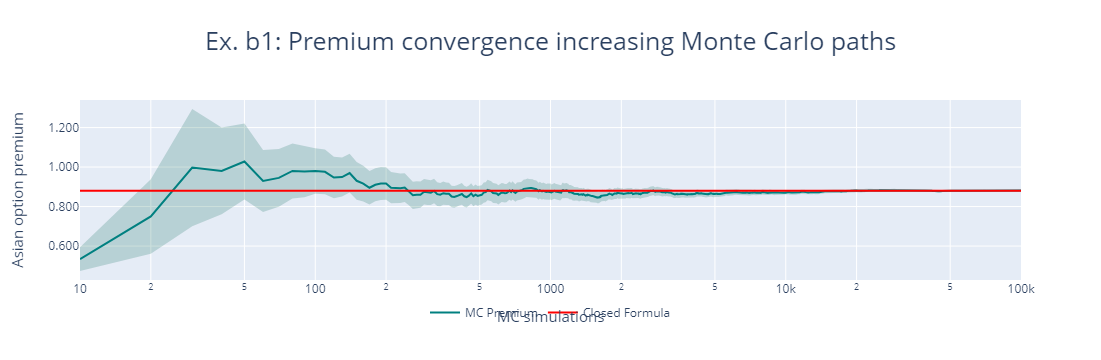

In [7]:
fig_b1 = go.FigureWidget()
fig_b1.add_trace(go.Scatter(x=paths_rng,y=mc_rng,fill='toself',fillcolor='rgba(0,100,80,0.2)',
                         line=dict(color='rgba(255,255,255,0)'),hoverinfo="skip",showlegend=False))
fig_b1.add_trace(go.Scatter(x=paths,y=exercise_b['MC_Premium'], name='MC Premium',line=dict(color='teal')))
fig_b1.add_trace(go.Scatter(x=paths,y=np.ones(len(a))*premium, name='Closed Formula',line=dict(color='red')))

fig_b1.layout.title={'text':'Ex. b1: Premium convergence increasing Monte Carlo paths','font':{'size': 25},'x':0.5,'xanchor':'center'}
fig_b1.layout.yaxis={'fixedrange': False, 'title': 'Asian option premium','titlefont':{'size': 15}, 'tickformat':'.3f','hoverformat':'.6f'}
fig_b1.layout.xaxis={'title': 'MC simulations', 'titlefont':{'size': 15}}
fig_b1.layout.showlegend = True
fig_b1.update_xaxes(type="log")
fig_b1.layout.legend={'orientation':'h','x':0.5,'xanchor':'center'}
fig_b1.layout.height = 650
fig_b1.layout.hovermode = 'x'
fig_b1.show()
#fig_b1.write_html('output/asian/Premium convergence increasing Monte Carlo paths (100 Euler steps).html')

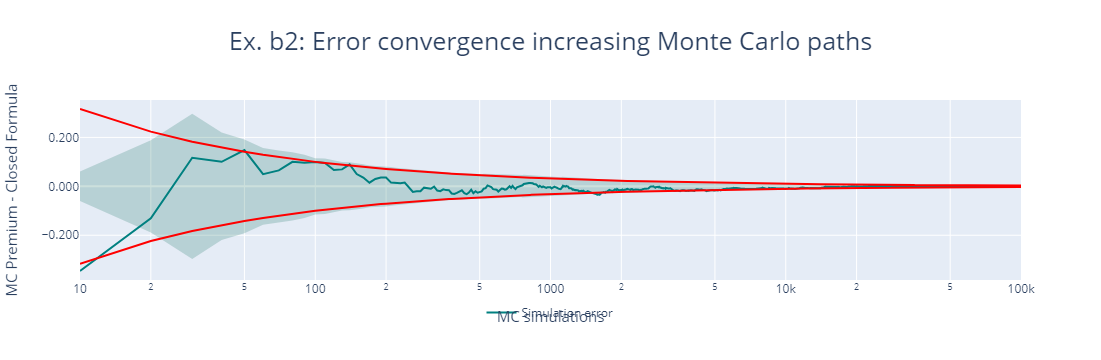

In [9]:
a = exercise_b['MC_Error'].tolist()
b = [-i for i in a]
error_rng = a+b[::-1]
fig_b2 = go.FigureWidget()
fig_b2.add_trace(go.Scatter(x=paths_rng,y=error_rng,fill='toself',fillcolor='rgba(0,100,80,0.2)',
                         line=dict(color='rgba(255,255,255,0)'),hoverinfo="skip",showlegend=False))
fig_b2.add_trace(go.Scatter(x=paths,y=exercise_b['Simulation_Error'], name='Simulation error',line=dict(color='teal')))
fig_b2.add_trace(go.Scatter(x=paths,y=1/(np.sqrt(paths)),name='Upper bound',showlegend=False, hoverinfo='skip',line=dict(color='Red')))
fig_b2.add_trace(go.Scatter(x=paths,y=-1/(np.sqrt(paths)),name='Lower bound',showlegend=False, hoverinfo='skip',line=dict(color='Red')))

fig_b2.layout.title={'text':'Ex. b2: Error convergence increasing Monte Carlo paths','font':{'size': 25},'x':0.5,'xanchor':'center'}
fig_b2.layout.yaxis={'fixedrange': False, 'title': 'MC Premium - Closed Formula','titlefont':{'size': 15},'tickformat':'.3f', 'hoverformat':'.6f'}
fig_b2.layout.xaxis={'title': 'MC simulations', 'titlefont':{'size': 15}}
fig_b2.layout.showlegend = True
fig_b2.update_xaxes(type="log")
fig_b2.layout.legend={'orientation':'h','x':0.5,'xanchor':'center'}
fig_b2.layout.height = 650
fig_b2.layout.hovermode = 'x'
fig_b2.show()
#fig_b2.write_html('output/asian/Error convergence increasing Monte Carlo paths (100 Euler steps).html')